In [6]:
import numpy as np
import numpy.random 
import math
import seaborn as sns
import warnings
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from random import randint

计算对数波动率

LSM计算潜在价值

In [7]:
S=390*0.25
X=33.6
r=0.00357
sigma=0.1
T=5
q=0.00#股利支付率

I=10000#path
M=1000#number of prices
dt=T/M


In [8]:
def quadratic_fitting(X,Y):
    X = np.array(X)
    Y = np.array(Y)
    S0,S1,S2,S3,S4 = len(X),sum(X),sum(X*X),sum(X**3),sum(X**4)
    V0,V1,V2 = sum(Y), sum(Y*X), sum(Y*X*X)
    coeff_mat = np.array([[S0,S1,S2],[S1,S2,S3],[S2,S3,S4]])#2阶函数
    target_vec = np.array([V0,V1,V2])
    inv_coeff_mat = np.linalg.inv(coeff_mat)#逆矩阵
    fitted_coeff = np.matmul(inv_coeff_mat,target_vec)#矩阵相乘
    resulted_Ys = fitted_coeff[0]+fitted_coeff[1]*X+fitted_coeff[2]*X*X
    return resulted_Ys
def reg2(x,y,n=2):
    corr=np.polyfit(x,y,n)
    Y=np.poly1d(corr)
    # print('Y',y)
    # print('pred',Y(x))
    return Y(x)
# def reg4(x,y):
#     x_1=np.exp(-0.5*x)
#     x_2=x_1*(1-x)
#     x_3=x_1*(1-2*x+x*x/2)
#     X=np.zeros(shape=(4,len(x)))
#     X[0]=x_1;X[1]=x_2;X[2]=x_3;X[3]=y
#     data=pd.DataFrame(X.T,columns=('X','XX','XXX','y'),dtype=float)
#     xinput=data[['X','XX','XXX']]
#     yinput=data[['y']]
#     Y=LinearRegression(fit_intercept=0)#fit_intercept=0
#     Y.fit(xinput,yinput)#Y.intercept_截距，Y.coef_回归系数，print
#     pred=Y.predict(xinput)
#     return pred.T
# def lookback_min_array(martix):#得到矩阵中每一列最小的值
#     res_array=[]
#     for j in range(len(martix[0])):
#         one_array=[]
#         for i in range(len(martix)):
#             one_array.append(int(martix[i][j]))
#         res_array.append(min(one_array))
#     return res_array    
# def lookback_max_array(martix):#得到矩阵中每一列最大的值
#     res_array=[]
#     for j in range(len(martix[0])):
#         one_array=[]
#         for i in range(len(martix)):
#             one_array.append(int(martix[i][j]))
#         res_array.append(max(one_array))
#     return res_array   

In [9]:
def gen_randompath(s=S,r=r,sigma=sigma,t=T,m=M,i=I):
    global dt
    standard=np.random.standard_normal((m+1,I))
    # standard=np.random.normal(loc=.35,scale=.2,size=(m+1,I))
    pricepath=np.zeros((m+1,I))
    pricepath[0]=s
    for n in range(1,m+1):
        pricepath[n]=pricepath[n-1]*np.exp((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*standard[n])
    return pricepath
def gen_randompath_q(s=S,r=r,sigma=sigma,t=T,m=M,i=I):#含分红
    global dt,q
    standard=np.random.standard_normal((m+1,I))
    pricepath=np.zeros((m+1,I))
    pricepath[0]=s
    for n in range(1,m+1):
        pricepath[n]=pricepath[n-1]*np.exp((r-q-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*standard[n])
    return pricepath

In [10]:
def lsm_call(path,K=X,r=r):
    global dt,M
    option_prices=np.maximum(path[-1,:]-K,0)
    for i in range(M-1,0,-1):
        option_prices*=np.exp(-r*dt)
        # option_prices=quadratic_fitting(path[i,:],option_prices)
        option_prices=reg2(path[i,:],option_prices,5)
        # option_prices=reg3(path[i,:],option_prices)
        # option_prices=reg4(path[i,:],option_prices)
        option_prices = np.maximum(option_prices,path[i,:]-K)
    option_prices *= np.exp(-r*dt)
    return option_prices.mean()
def lsm_call_dual(path,path_dual,K=X,r=r):
    global dt,M
    option_prices_1=np.maximum(path_dual[-1,:]-K,0)
    option_prices=np.maximum(path[-1,:]-K,0)
    for i in range(M-1,0,-1):
        option_prices*=np.exp(-r*dt)
        # option_prices=quadratic_fitting(path[i,:],option_prices)
        option_prices=reg2(path[i,:],option_prices,2)
        # option_prices=reg3(path[i,:],option_prices)
        # option_prices=reg4(path[i,:],option_prices)
        option_prices = np.maximum(option_prices,path[i,:]-K)

        option_prices_1*=np.exp(-r*dt)
        option_prices_1=reg2(path_dual[i,:],option_prices_1,n=2)
        option_prices_1 = np.maximum(option_prices_1,path_dual[i,:]-K)
    option_prices *= np.exp(-r*dt)
    option_prices_1 *= np.exp(-r*dt)
    return (option_prices.mean()+option_prices_1.mean())/2,option_prices.mean(),option_prices_1.mean()
# def lsm_put(path,K=X):
#     global dt,M,r
#     option_prices=np.maximum(K-path[-1,:],0)
#     for i in range(M-1,0,-1):
#         option_prices *= np.exp(-r*dt)
#         option_prices = reg2(path[i,:], option_prices,5)
#         option_prices = np.maximum(option_prices,K-path[i,:])
#     option_prices *= np.exp(-r*dt)
#     return option_prices.mean()
# def EUR_call(path,K=X):
#     global dt,M,r,T
#     option_prices=np.exp(-r*T)*np.maximum(path[-1,:]-K,0)
#     return option_prices.mean()
# def EUR_put(path,K=X):
#     global dt,M,r,T
#     option_prices=np.exp(-r*T)*np.maximum(K-path[-1,:],0)
#     return option_prices.mean()
# def lookbackoption_EUR_call(path,K=X):
#     global dt,M,r,T
#     Pmax=lookback_max_array(path)
#     option_prices=np.exp(-r*T)*np.maximum(np.array(Pmax)-K,0)
#     return option_prices.mean()
# def lookbackoption_EUR_put(path,K=X):
#     global dt,M,r,T
#     Pmin=lookback_min_array(path)
#     option_prices=np.exp(-r*T)*np.maximum(K-np.array(Pmin),0)
#     return option_prices.mean()
# def Asian_call(path,K=X):
#     global dt,M,r,T
#     option_prices=np.exp(-r*T)*np.maximum(np.mean(path,axis=0)-K,0)
#     return option_prices.mean()
# def Asian_put(path,K=X):
#     global dt,M,r,T
#     option_prices=np.exp(-r*T)*np.maximum(K-np.mean(path,axis=0),0)
#     return option_prices.mean()

In [11]:
warnings.filterwarnings('ignore')
with np.errstate(divide='ignore'):
    np.float64(1.0)/0.0
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.style.core.use('seaborn-dark-palette')
# np.set_printoptions(precision=4)

In [12]:
path=gen_randompath_q();path_dual=gen_randompath_q()
# AMer_c=lsm_call(path)
AMer_c_d=lsm_call_dual(path,path_dual)
# print(AMer_c,AMer_c_d)
# AMer_p=lsm_put(path)
# EUR_c=EUR_call(path)
# EUR_p=EUR_put(path)
# lookback_c=lookbackoption_EUR_call(path)
# lookback_p=lookbackoption_EUR_put(path)
# Asian_c=Asian_call(path)
# Asian_p=Asian_put(path)
print('数据资产潜在价值评估结果为：%.4f'%AMer_c_d[0])

数据资产潜在价值评估结果为：64.5916


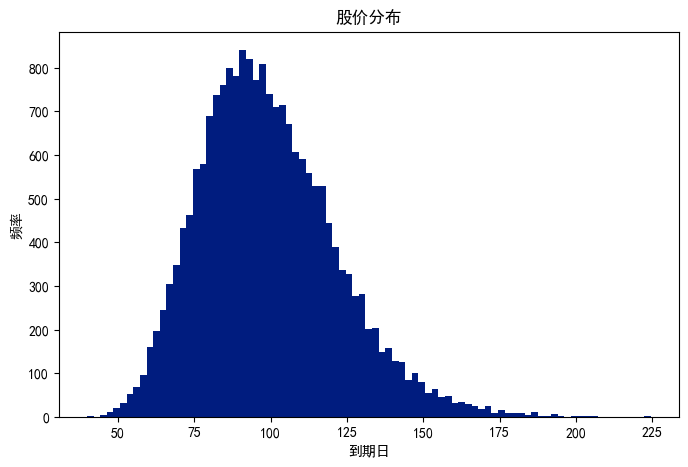

In [13]:
plt.figure(figsize=(8,5))
plt.hist(np.append(path[-1],path_dual[-1]),bins=85)
# plt.hist((path[-1]+path_dual[-1])/2,bins=40)
plt.xlabel('到期日')
plt.ylabel('频率')
plt.title('股价分布')
plt.show()

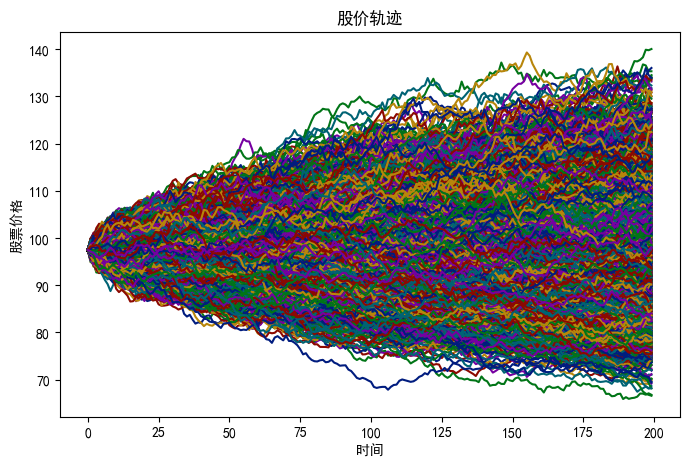

In [14]:
plt.figure(figsize=(8,5))
plt.plot(path[:200],lw=1.5)
plt.xlabel('时间')
plt.ylabel('股票价格')
plt.title('股价轨迹')
plt.show()

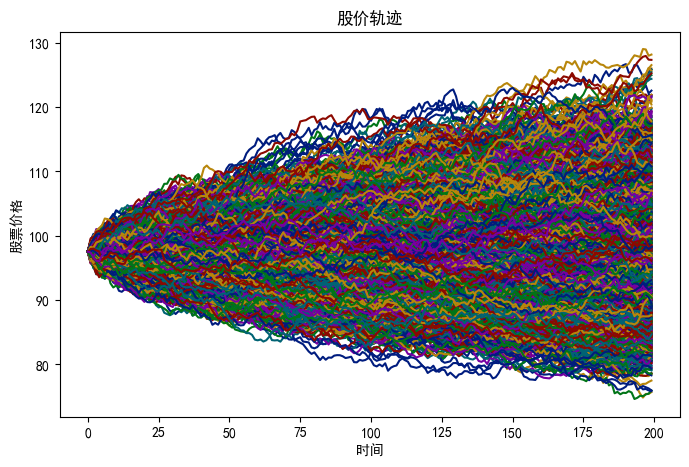

In [15]:
plt.figure(figsize=(8,5))
plt.plot((path[:200]+path_dual[:200])/2,lw=1.5)
plt.xlabel('时间')
plt.ylabel('股票价格')
plt.title('股价轨迹')
plt.show()

In [16]:
def imitate():
    path=gen_randompath_q();path_dual=gen_randompath_q()
    AMer_c=lsm_call_dual(path,path_dual)
    return AMer_c[0]
Times=233
sim=np.zeros(Times)
for num in range(Times):
    sim[num]=imitate()
sim_lo=np.percentile(sim,5,axis=0);sim_hi=np.percentile(sim,95,axis=0)
# sim_ad=np.append(np.where(sim>float(sim_lo)),np.where(sim<float(sim_hi)))
sim_ad=[i for i in list(sim) if (i<sim_hi) & (i> sim_lo) ]#条件括起

209


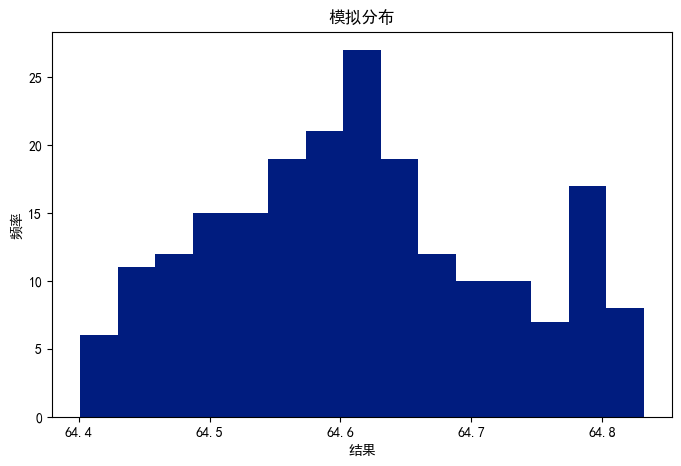

In [17]:
plt.figure(figsize=(8,5))
plt.hist(sim_ad,bins=15);print(len(sim_ad))
plt.xlabel('结果')
plt.ylabel('频率')
plt.title('模拟分布')
plt.show()

In [21]:
print('试验次数:%d,平均值:%.4f,中间值:%.4f,标准差:%.4f,最大值:%.4f,最小值:%.4f'%(Times,np.mean(sim_ad),np.median(sim_ad),np.std(sim_ad),np.max(sim_ad),np.min(sim_ad)))
print(M)

试验次数:233,平均值:64.6122,中间值:64.6082,标准差:0.1082,最大值:64.8320,最小值:64.4011
1000


创新点——参数调整与改进；采用对偶模拟

In [19]:
# print(path[0,:],path[1,:])
randominterger=randint(0,1000-1)
x_ad=path[randominterger,:]
y_ts=np.maximum(path[-1,:]-X,0)
y_ts*=np.exp(-r*dt)
y_pr_reg2=reg2(x=x_ad,y=y_ts,n=5)
y_pr_reg2 = np.maximum(y_pr_reg2,path[randominterger,:]-X)
y_pr_reg2=[i for i in y_pr_reg2 if (i != np.inf)&(i != np.inf)]
y_pr_base=quadratic_fitting(x_ad,y_ts)
print('五阶模型r2:%.4f;二阶模型r2:%.4f'%(r2_score(y_true=y_ts,y_pred=y_pr_reg2),r2_score(y_true=y_ts,y_pred=y_pr_base)))
# print('五阶模型rmse:%.4f;二阶模型rmse:%.4f'%(np.sqrt(mean_absolute_error(np.log(y_ts),np.log(y_pr_reg2))),np.sqrt(mean_absolute_error(np.log(y_ts),np.log(y_pr_base)))))
print('五阶模型mae:%.4f;二阶模型mae:%.4f'%(mean_absolute_error(y_ts,y_pr_reg2),mean_absolute_error(y_ts,y_pr_base)))
# print('五阶模型msle:%.4f;二阶模型msle:%.4f'%(mean_squared_log_error(y_ts,y_pr_reg2),mean_squared_log_error(y_ts,y_pr_base)))
# print('五阶模型rmse:%.4f;二阶模型rmse:%.4f'%(np.sqrt(mean_squared_error(y_ts,y_pr_reg2)),np.sqrt(mean_squared_error(y_ts,y_pr_base))))


五阶模型r2:0.4120;二阶模型r2:0.4112
五阶模型mae:13.4936;二阶模型mae:13.5041


敏感性分析

Text(0, 0.5, '估值')

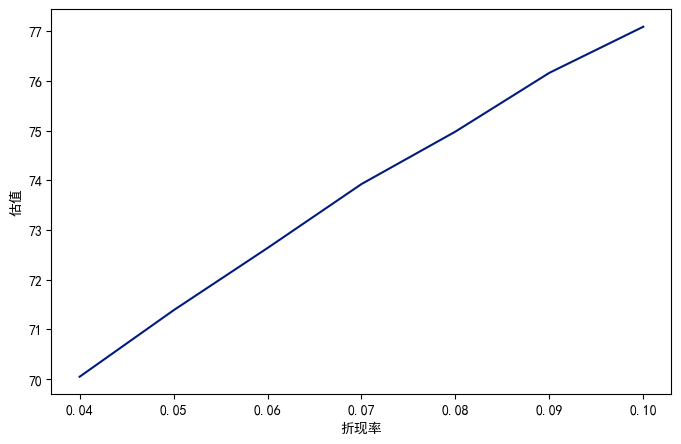

In [22]:
r_sa=[i/100 for i in range(4,11,1)]
sensitivity_analysis=[]
for r_t in r_sa:
    test=[]
    for t in range(10):
        path_sa=gen_randompath_q(r=r_t)
        test.append(lsm_call(path=path_sa,r=r_t))
    sensitivity_analysis.append(np.mean(test))
plt.figure(figsize=(8,5))
plt.plot(r_sa,sensitivity_analysis)
plt.xlabel('折现率')
plt.ylabel('估值')

AHP

In [ ]:
def check(A):
    eigen = np.linalg.eig(A)[0]
    n = A.shape[0]
    CI = (max(eigen) - n) / (n - 1)
    RI = [0,0, 0.52, 0.89, 1.12, 1.26, 1.36, 1.41, 1.46, 1.49, 1.52, 1.54, 1.56, 1.58, 1.59]#查表
    CR = CI / RI[n - 1]
    CI = float(CI)
    CR = float(CR)
    # 若CI过小，为防止计算误差出现，取0即可
    if abs(CI) < 0.0001:
        CI = 0
    if abs(CR) < 0.0001:
        CR = 0
    print('The CI is:%.4f'%CI)
    print('The CR is:%.4f'%CR)
    if CR < 0.1:
        return 1 #通过
    else:
        return 0  # 对CR进行判断，用于下面计算权重函数。


# 计算权重函数
def count_p(A):
    q = check(A)
    n = A.shape[0]
    while q:
        weight1 = (np.sum(A / np.sum(A, axis=0), axis=1)) / n  # 算术平均权重
        weight2 = pow(np.prod(A, axis=1), 1 / n) / np.sum(pow(np.prod(A, axis=0), 1 / n))  # 几何平均权重
        eigen, F_vector = np.linalg.eig(A)
        for i in range(n):
            if eigen[i] == np.max(eigen):
                index_e = i
        best = F_vector[:, index_e]
        weight3 = best / np.sum(best)  # 特征值权重
        #print(weight1, '\n', weight2, '\n', weight3, '\n')
        return weight1,weight2,weight3.real,best.real
    else:
        print('Consistency check not pass')
        return 0, 0, 0


# 数据获取与处理
def AHP(name=r'./AHP.txt'):
    tx = open(name).readlines()#tx0 目标与准则 tx1-5 方案与准则 准则层在左上角 判断矩阵
    for i in range(len(tx)):
        tx[i] = np.array(list(eval(tx[i])))
        n0 = int((np.size(tx[i])) ** 0.5)
        tx[i] = tx[i].reshape(n0, n0)
    A0 = tx[0]
    print('目标与准则\n%s'%A0)
    o_c1, o_c2, o_c3,o_b = count_p(A0)
    print('特征值权重\n%s'%o_c3)#shape(1,5)
    print('特征值向量\n%s'%o_b)
    C_P = []
    for Ai in tx[1:]:
        print('方案与准则\n%s'%Ai)
        c_p1, c_p2, c_p3,c_b = count_p(Ai)
        print('特征值权重\n%s'%c_p3)
        print('特征值向量\n%s'%np.abs(c_b))
        C_P.append(list(c_p3))
    #
    c_p = np.array(C_P)
    # print(c_p)#shape(5,3)
    score = []
    for i in range(len(c_p[0, :])):
        score.append(sum(o_c3 * c_p[:, i]))  # 计算权重
    #
    print('打分%s\n无形资产收益得分(M)%.4f'%(np.array(score),score[0]))
    return score
M=AHP(name='./AHP.txt')[0]

目标与准则
[[1.         3.         2.        ]
 [0.33333333 1.         0.5       ]
 [0.5        2.         1.        ]]
The CI is:0.0046
The CR is:0.0088
特征值权重
[0.53961455 0.16342412 0.29696133]
特征值向量
[0.84679693 0.25645536 0.46601031]
方案与准则
[[1.         2.         4.         6.        ]
 [0.5        1.         2.         3.        ]
 [0.25       0.5        1.         2.        ]
 [0.16666667 0.33333333 0.5        1.        ]]
The CI is:0.0035
The CR is:0.0039
特征值权重
[0.51951964 0.25975982 0.13995012 0.08077042]
特征值向量
[0.86170437 0.43085218 0.23212911 0.13397034]
方案与准则
[[1.         0.16666667 0.2        0.5       ]
 [6.         1.         2.         3.        ]
 [5.         0.5        1.         2.        ]
 [2.         0.33333333 0.5        1.        ]]
The CI is:0.0082
The CR is:0.0092
特征值权重
[0.07089086 0.48414798 0.29582907 0.14913208]
特征值向量
[0.11996805 0.81931979 0.5006292  0.25237503]
方案与准则
[[1.         2.         5.         2.        ]
 [0.5        1.         3.         1.        ]
 [0